# XGB test

In [1]:
%load_ext autoreload
%autoreload 2

# %matplotlib widget

In [2]:
import pandas as pd

import seaborn as sns

from math import log, floor

import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm

from xgboost import XGBRegressor
import shap


from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold

from plots2.fns import (
    # standard_layout,
    # corner_annotations_colwise,
    # corner_annotations_rowwise,
    # get_text_annotation,
    get_corner_annotations,
    get_corner_annotations_custom_labels,
    # get_corner_annotations_explicit
)

from plots2.consts import (
    SMALL_FONT,
    MEDIUM_FONT,
    BIGGER_FONT,
    SHAP_BLUE
)

from poly2.utils import trait_vec, gamma_dist, object_dump, object_load
# from poly2.shap import get_shap_values
# from poly2.run import no_joblib_single_run, no_joblib_multiple_run
from poly2.config import Config, ConfigMixture, get_asymptote_config
# from poly2.simulator import SimulatorOneTrait, SimulatorAsymptote

C:\Users\user\anaconda3\envs\poly2\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [3]:
df = pd.read_csv('../outputs/combined/scan_all.csv')

df.head()

,run,year,best_dose,n_pos_diff,in_0p0_0p1,in_0p1_0p2,in_0p2_0p3,in_0p3_0p4,in_0p4_0p5,in_0p5_0p6,...,in_0p8_0p9,in_0p9_1p0,mu,b,asymptote,dec_rate_multiplier,m_prop_multiplier,m_scale_multiplier,ME_var,ME_mean
0,0,1,1.0,9,1.0,5.054079e-27,7.584700e-34,1.472094e-39,4.846678e-45,9.976588e-51,...,2.492945e-74,3.501367e-90,17.879734,2.744068,0.602763,1.786355,0.703574,1.95789,5.044122e-17,0.398241
1,0,2,1.0,9,1.0,5.054079e-27,7.584700e-34,1.472094e-39,4.846678e-45,9.976588e-51,...,2.492945e-74,3.501367e-90,17.879734,2.744068,0.602763,1.786355,0.703574,1.95789,5.044122e-17,0.398241
2,0,3,1.0,9,1.0,5.054079e-27,7.584700e-34,1.472094e-39,4.846678e-45,9.976588e-51,...,2.492945e-74,3.501367e-90,17.879734,2.744068,0.602763,1.786355,0.703574,1.95789,5.044122e-17,0.398241
3,0,4,1.0,9,1.0,5.054079e-27,7.584700e-34,1.472094e-39,4.846678e-45,9.976588e-51,...,2.492945e-74,3.501367e-90,17.879734,2.744068,0.602763,1.786355,0.703574,1.95789,5.044122e-17,0.398241
4,0,5,1.0,9,1.0,5.054079e-27,7.584700e-34,1.472094e-39,4.846678e-45,9.976588e-51,...,2.492945e-74,3.501367e-90,17.879734,2.744068,0.602763,1.786355,0.703574,1.95789,5.044122e-17,0.398241


In [4]:
X = (
    # df_filt
    df
    .drop([
        'best_dose',
        'n_pos_diff',
        'ME_var',
        # 'ME_mean',
        # 'yld',
        # 'cum_yld',
    ], axis=1)
    .filter(regex='^((?!in_0).)*$')
    .rename(columns = {
        'dec_rate_multiplier': 'dec_rate',
        'm_prop_multiplier': 'm_prop',
        'm_scale_multiplier': 'm_scale',
        'asymptote': 'asymp',
    })
    
#     .drop('ME_mean', axis=1)
#     .assign(a = lambda x: x.b*x.mu)
#     .assign(nu = lambda x: (x.b)**(x.a) / (1 + x.b)**(x.a))
#     .assign(ME_mean = lambda x: 1 - x.asymp + x.asymp * x.nu)
    
#     .drop(['a', 'nu'], axis=1)
)

# y = df_filt.loc[:, ['run', 'best_dose']]
y = df.loc[:, ['run', 'best_dose']]

X.head()

,run,year,mu,b,asymp,dec_rate,m_prop,m_scale,ME_mean
0,0,1,17.879734,2.744068,0.602763,1.786355,0.703574,1.95789,0.398241
1,0,2,17.879734,2.744068,0.602763,1.786355,0.703574,1.95789,0.398241
2,0,3,17.879734,2.744068,0.602763,1.786355,0.703574,1.95789,0.398241
3,0,4,17.879734,2.744068,0.602763,1.786355,0.703574,1.95789,0.398241
4,0,5,17.879734,2.744068,0.602763,1.786355,0.703574,1.95789,0.398241


In [5]:
# reset index? Might help with Int64Index XGB warning
X_cv = X.loc[lambda x: (x.run<8000)].drop('run', axis=1)
y_cv = y.loc[lambda x: (x.run<8000)].drop('run', axis=1)

X_test = X.loc[lambda x: (x.run>=8000)].drop('run', axis=1)
y_test = np.array(y.loc[lambda x: (x.run>=8000)].drop('run', axis=1))

## Squared error

In [6]:
%%time

xgb = XGBRegressor()

xgb.load_model('xgb_scan_all_cumulative.json')

Wall time: 3.25 s


In [7]:
%%time

xgb.fit(X_cv, y_cv)

y_p = xgb.predict(X_test)

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


Wall time: 2min 23s


## Pseudo huber error

In [8]:
hyperparams = (
    pd.read_csv('../outputs/best_XGB_hyperparams.csv')
    .iloc[0]
    .to_dict()
)

hyperparams['max_depth'] = int(hyperparams['max_depth'])
hyperparams['n_estimators'] = int(hyperparams['n_estimators'])

hyperparams['objective'] = 'reg:pseudohubererror'

hyperparams

{'max_depth': 10,
 'n_estimators': 853,
 'learning_rate': 0.0182387397607204,
 'subsample': 0.721624617726085,
 'colsample_bytree': 0.943486029986996,
 'objective': 'reg:pseudohubererror'}

In [9]:
%%time

xgb2 = XGBRegressor(**hyperparams)

xgb2.fit(X_cv, y_cv)

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


Wall time: 2min 4s


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.943486029986996,
             enable_categorical=False, gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.0182387397607204,
             max_delta_step=0, max_depth=10, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=853, n_jobs=8,
             num_parallel_tree=1, objective='reg:pseudohubererror',
             predictor='auto', random_state=0, reg_alpha=0, reg_lambda=1,
             scale_pos_weight=1, subsample=0.721624617726085,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [10]:
y_p2 = xgb2.predict(X_test)

## Plot

In [11]:
mean_squared_error(y_p, y_test[:, 0], squared=False)

0.1086953213543925

In [12]:
mean_squared_error(y_p2, y_test[:, 0], squared=False)

0.10868153916874275

In [13]:
pdf = pd.DataFrame(dict(
    Model=y_p,
    Model2=y_p2,
    Data=y_test[:, 0],
))

In [14]:
pdf.describe()

,Model,Model2,Data
count,70000.000000,70000.000000,70000.000000
mean,0.809352,0.809475,0.809496
std,0.302988,0.303268,0.331834
min,0.009045,-0.002695,0.100000
25%,0.708889,0.707529,0.700000
50%,0.988913,0.988678,1.000000
75%,1.001223,1.001270,1.000000
max,1.113598,1.103588,1.000000


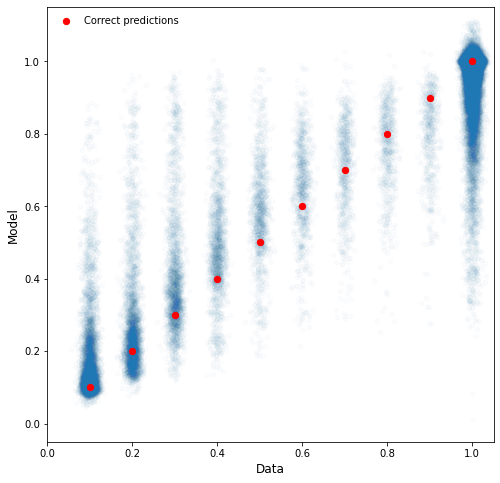

In [15]:
plt.rc('font', size=SMALL_FONT)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_FONT)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_FONT)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_FONT)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_FONT)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_FONT)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_FONT)  # fontsize of the figure title

# rows = 7
# cols = 7

f, ax = plt.subplots(figsize=(8,8))

(
    pdf
    .assign(jittered = lambda x: x.Data + np.random.normal(0, 0.01, x.shape[0]))
    .plot
    .scatter(
        x='jittered',
        y='Model',
        alpha=0.015,
        # alpha=0.05,
        ax=ax,
    )
)


ax.scatter(np.arange(0.1, 1.1, 0.1), np.arange(0.1, 1.1, 0.1), c='r', s=40, label='Correct predictions')
        
ax.set_xlim([0, 1.05])
ax.set_ylim([-0.05, 1.15])

ax.set_xlabel('Data')
ax.set_ylabel('Model')

# plt.tight_layout(rect=[0,0,1,0.95])

ax.legend(
    loc='upper left',
    # bbox_to_anchor=(2.1, 1.2),
    # ncol=2,
    framealpha=0,
)

In [16]:
pdf.corr()

,Model,Model2,Data
Model,1.000000,0.999033,0.945382
Model2,0.999033,1.000000,0.945368
Data,0.945382,0.945368,1.000000


# Save

In [17]:
f.savefig('../figures/paper/appm_fig2.jpg', dpi=300, bbox_inches="tight")

In [18]:
from scipy.stats import linregress

In [19]:
# slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x, y)
slope, intercept, r_value, p_value, std_err = linregress(pdf.Data, pdf.Model)

r_value**2

0.8937480104146672

In [20]:
linregress(pdf.Data, pdf.Model2)

LinregressResult(slope=0.8639881035601774, intercept=0.11007902634501376, rvalue=0.9453676435471405, pvalue=0.0, stderr=0.0011261338779527967, intercept_stderr=0.0009852196775831353)